# Week 7: Multilevel Modelling

## **Notebook Overview**

This notebook is available on github
[here](https://github.com/Yushi-Y/AAS-ongoing-tutorials). If you find errors or would like to suggest an improvement then let me know.

This week is about multilevel modelling. The first set of questions are about the Variance Components Model and the last few are about the Random Intercept Model. Note that we don't cover Random Slope Models in this notebook.

[Multilevel models](https://en.wikipedia.org/wiki/Multilevel_model) are a family of models and we just consider a couple of them in this course.

### **Additional Resources**

1. **Fox Textbook:** Page 699 onwards
2. [Wikipedia](https://en.wikipedia.org/wiki/Multilevel_model): Okay but a lot of topics so may be hard to find exact what you're looking for.
3. [Ben Lambert](https://www.youtube.com/watch?v=Tn5y2i_MqQ8): Likelihood Ratio tests. Useful generally but you'll need to apply one in this context in the problem set.

If anyone finds any other good resources then email/Teams me and I'll add them to the list for future years.


As usual we will start by importing some useful libraries.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import matplotlib.pyplot as plt

# Salaries for Professors

The 2008--09 nine-month academic salary for Assistant Professors, Associate
Professors and Professors in a college in the U.S. The data were collected as
part of the on-going effort of the college's administration to monitor salary
differences between male and female faculty members.

- `rank` a factor with levels `AssocProf`` `AsstProf`` `Prof`.
- `discipline` a factor with levels `A` ("theoretical" departments) or ``B`` ("applied" departments).
- `yrs.since.phd` years since PhD.
- `yrs.service` years of service.
- `sex` a factor with levels `Female` `Male`.
- `salary` nine-month salary, in dollars.

This data comes with the `statsmodels` package along with some metadata. Here we
will rename a couple of variables so they are a bit easier to access.

In [ ]:
# Load the data
salaries_dataset = sm.datasets.get_rdataset("Salaries", "carData")
#print(salaries_dataset.__doc__) # Uncomment to see salaries

# Read into a df and update the column names
salaries_df = salaries_dataset.data
salaries_df = salaries_df.rename(columns={"yrs.since.phd": "years_post_phd", "yrs.service": "years_service", "rank": "job"})

We can use a scatter plot to get an idea for how the salary changes. There is a general trend that the salary increases through time, but the variance appears to change.

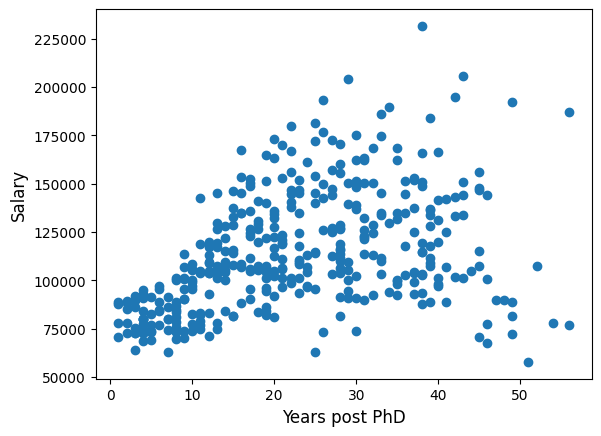

In [ ]:
# Plot a simple scatter of salary against years post PhD
plt.figure()
plt.scatter(salaries_df.years_post_phd, salaries_df.salary)
plt.xlabel("Years post PhD", fontsize="large")
plt.ylabel("Salary", fontsize="large")
plt.show()

If we colour these points based on the professors' ranks a very different
pattern emerges

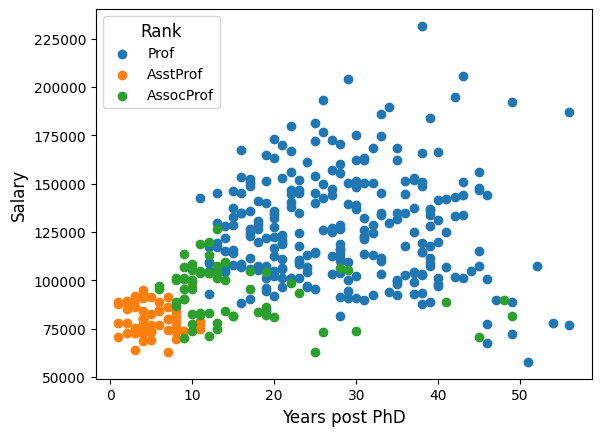

In [ ]:
# Extract the unique jobs
jobs = salaries_df["job"].unique()

# Plot scatters for each type of job
plt.figure()
for job in jobs:
    tmp = salaries_df[salaries_df["job"] == job]
    plt.scatter(tmp.years_post_phd, tmp.salary, label = job)
plt.legend(title = "Rank", title_fontsize = "large")
plt.xlabel("Years post PhD", fontsize="large")
plt.ylabel("Salary", fontsize="large")
plt.show()

### Question 1

What assumption of the variance component model clearly does not hold for this data set? Use some code to back up your statement.

### Answer

The within group variance is differs wildly!

In [ ]:
# Return the mean and standard deviation for group
for job in jobs:
    print(job)
    print("mean: " + str(salaries_df[salaries_df["job"] == job].salary.mean()))
    print("scale: " + str(salaries_df[salaries_df["job"] == job].salary.std()))

Prof
mean: 126772.1090225564
scale: 27718.674998951574
AsstProf
mean: 80775.98507462686
scale: 8174.1126373976995
AssocProf
mean: 93876.4375
scale: 13831.699843745177


# Simulation

Before we analyse this data we should familiarise ourselves with the functionality provided by `statsmodels`. To have a data set where we know the "true" values we will simulate a very similar dataset. Note that we have set the mean values for each rank to the true values and set a constant scale across all the jobs of $15000$ (note $15000^{2} = 225000000$). The "years post PhD" is sampled randomly from a Poisson distribution with a relevant mean.

In [ ]:
# Generate an array of 100 repeats of each job
demo_job = np.repeat(a=['Prof', 'AsstProf', 'AssocProf'], repeats=100)

# Generate an array of random years post PhD using the relevant means
demo_ypp = np.concatenate(
    (stats.poisson.rvs(30, size = 100),
    stats.poisson.rvs(5, size = 100),
    stats.poisson.rvs(15, size = 100)))

# Define the salary means and scale
demo_salary_means = [126772,80775,93876]
demo_salary_scale = 15000

# Generate random salaries from a normal distribution where the means and variances are as above
demo_salary = stats.norm.rvs(loc = np.repeat(a=demo_salary_means, repeats=100), scale = demo_salary_scale, size = 300)

# Turn this into a df
demo_df = pd.DataFrame({'job': demo_job,
                      'years_post_phd': demo_ypp,
                       'salary': demo_salary})

# Extract the list of jobs again
jobs = demo_df["job"].unique()

We can use the same plotting code from before to confirm that this is a relevant dataset to work with.

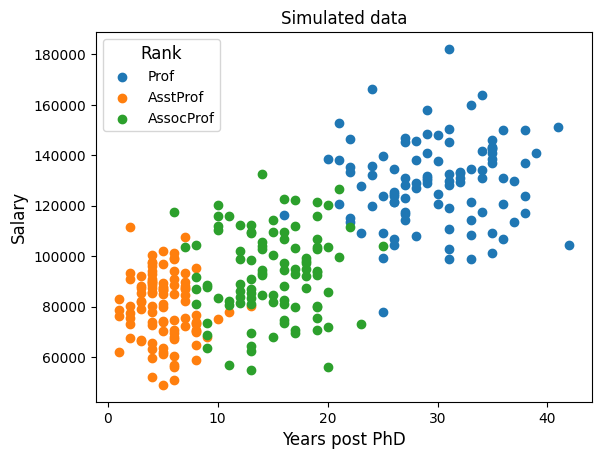

In [ ]:
# Same plot as before but for our simulated data
plt.figure()
for job in jobs:
    tmp = demo_df[demo_df["job"] == job]
    plt.scatter(tmp.years_post_phd, tmp.salary, label = job)
plt.title("Simulated data")
plt.legend(title = "Rank", title_fontsize = "large")
plt.xlabel("Years post PhD", fontsize="large")
plt.ylabel("Salary", fontsize="large")
plt.show()

### Question 2

As a way to get a rough idea of the components of the variance, estimate the variance among the known means and use it to compute the variance partition coefficient (VPC) for the simulated dataset. Obviously since we are estimating the variance based on a data set of size 3 we should not put too much faith in the results.

### Answer

This is a really stupid way to do things. Very naive.

In [ ]:
# Get an array of the means (from earlier)
tmp = np.array(demo_salary_means)

# Estimate the variance in these means using the standard formula
naive_group_var_est = 0.5 * np.power(tmp - tmp.mean(), 2).sum()

# Consider the fraction of the total variance
naive_vpc = naive_group_var_est / (demo_salary_scale**2 + naive_group_var_est)
print(f"Naive VPC: {naive_vpc:.2f}")

Naive VPC: 0.71


### Question 3

Write down a way to describe the salaries with a variance components model. What parameters will be estimated?

Just use text for this but add mathematical equations.

### Answer

Let $s_{ij}$ be the salary of individual $i$ with job $j$ then

$$
s_{ij} = \beta_{0} + u_{j} + e_{ij}
$$

where $u_{j} \sim N(0, \sigma_{u}^{2})$ and $e_{ij} \sim N(0, \sigma_{e}^{2})$.

The parameters that will be estimated are $\beta_{0}$, and $\sigma_{u}^{2}$ and $\sigma_{e}^{2}$.

### Question 4

The following cell fits this model to the data. What are the estimated parameter values?

Hint: Due to an odd choice of names, the "Scale" parameter in the summary is the individual level variance.

In [ ]:
# Fit the model
mlm_0 = smf.mixedlm(formula = "salary ~ 1", data = demo_df, groups = demo_df.job).fit()
mlm_0.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:              MixedLM   Dependent Variable:   salary        
No. Observations:   300       Method:               REML          
No. Groups:         3         Scale:                250205360.7612
Min. group size:    100       Log-Likelihood:       -3323.6721    
Max. group size:    100       Converged:            Yes           
Mean group size:    100.0                                         
------------------------------------------------------------------
              Coef.      Std.Err.   z   P>|z|   [0.025    0.975]  
------------------------------------------------------------------
Intercept    100733.273 14703.127 6.851 0.000 71915.674 129550.872
Group Var 646043746.501 41107.206                                 
==================================================================

"""

### Answer

Note that because the data here have been randomly generated you may get different numbers...

- $\hat{\beta}_{0} = 1.0 \times 10^{5}$
- $\hat{\sigma}_{u}^{2} = 5.5 \times 10^{8}$
- $\hat{\sigma}_{e}^{2} = 2.3 \times 10^{8}$

### Question 5

Does this look reasonable?

Hint: Compare the model results with the averages from simulated data.

### Answer

The value of $\beta_{0}$ (the global mean) looks reasonable given the values we simulated with and the individual level variance is approximately correct as shown in the following snippet. Given there are only three jobs (groups) it is harder to investigate if we are getting the scale correct there.

In [ ]:
individual_var_est = mlm_0.scale
print(f"Estimated individual salary scale: {np.sqrt(individual_var_est):.2e}")
print(f"True individual salary scale (from simulation): {demo_salary_scale:.2e}")

print(f"\nEstimated average salary: {mlm_0.params.Intercept:.2e}")
print(f"True average salary (from simulation): {demo_df.salary.mean():.2e}")

Estimated individual salary scale: 1.58e+04
True individual salary scale (from simulation): 1.50e+04

Estimated average salary: 1.01e+05
True average salary (from simulation): 1.01e+05


### Question 6

Compute the VPC from the model fit. Does it agree with the previous estimate?

### Answer

Yes

In [ ]:
# Extract the group variance
group_var = float(mlm_0.summary().tables[1]["Coef."]["Group Var"])

# Consider what fraction of total variance it is
vpc = group_var / (group_var + individual_var_est)

# Return the comparison
print(f"Naive VPC: {naive_vpc:.2f}")
print(f"Model VPC: {vpc:.2f}")

Naive VPC: 0.71
Model VPC: 0.72


### Question 7

Test whether including the effects of job is important in this model.

Hint: Use a likelihood ratio test for this.

### Answer

The case of no job level effect is a nested model so we can use a chi-squared test to reject the null hypothesis that there is no random effect at the job level.

In [ ]:
# Run the new model
lm_1 = smf.ols(formula = "salary ~ 1", data = demo_df).fit()
mlm_llhd = mlm_0.llf

print("MLM log-likelihood")
print(mlm_llhd, "\n")

lm_llhd = lm_1.llf
print("LM log-likelihood")
print(lm_llhd, "\n")

my_chi = -2 * (lm_llhd - mlm_llhd)
print("Chi-squared statistic")
print(my_chi, "\n")

print("p-value")
print(1 - stats.chi2.cdf(my_chi, df=1))

MLM log-likelihood
-3323.6721244136497 

LM log-likelihood
-3476.4094858692533 

Chi-squared statistic
305.4747229112072 

p-value
0.0


### Question 8

If we were to add `years_post_phd` as a covariate, what sort of model would this be? What was the name given to this type of model in the lecture?

### Answer

It would be a random intercept model.



### Question 9

Fit the model including the `years_post_phd` as a covariate. Does this parameter have a significant association?

### Answer

No, as expected since the salaries were simulated independent of this value (given the job).

In [ ]:
mlm_1 = smf.mixedlm(formula = "salary ~ 1 + years_post_phd", groups = demo_df.job, data = demo_df).fit()
mlm_1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                 MixedLM    Dependent Variable:    salary        
No. Observations:      300        Method:                REML          
No. Groups:            3          Scale:                 250439656.4334
Min. group size:       100        Log-Likelihood:        -3316.7154    
Max. group size:       100        Converged:             Yes           
Mean group size:       100.0                                           
-----------------------------------------------------------------------
                   Coef.      Std.Err.   z   P>|z|   [0.025    0.975]  
-----------------------------------------------------------------------
Intercept          96454.999 13548.909 7.119 0.000 69899.625 123010.372
years_post_phd       258.350   234.812 1.100 0.271  -201.874    718.574
Group Var      502853283.317 33068.132                                 
=======================================================================

"""

### Question 10

Apply the methodology above to establish if `years_post_phd` has a significant association with a Professor's salary while adjusting for random job-specific effects.

### Answer

This model does not find a significant correlation

In [ ]:
mlm_2 = smf.mixedlm(formula = "salary ~ 1 + years_post_phd", groups = salaries_df.job, data = salaries_df).fit()
mlm_2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM     Dependent Variable:     salary        
No. Observations:     397         Method:                 REML          
No. Groups:           3           Scale:                  559427686.2493
Min. group size:      64          Log-Likelihood:         -4551.4182    
Max. group size:      266         Converged:              Yes           
Mean group size:      132.3                                             
------------------------------------------------------------------------
                   Coef.      Std.Err.   z    P>|z|   [0.025    0.975]  
------------------------------------------------------------------------
Intercept         101625.056 14327.729  7.093 0.000 73543.223 129706.889
years_post_phd       -64.770   129.922 -0.499 0.618  -319.413    189.874
Group Var      596087722.791 25613.757                                  
========================================================================

"""

### Question 11

How much of the variance is explained by the professors rank?

### Answer

In [ ]:
print(f"VPC: {596087722.791 / (559427686.2493 + 596087722.791):.3f}")

VPC: 0.516


In [ ]:
group_var = float(mlm_2.summary().tables[1]["Coef."]["Group Var"])
ind_var = mlm_2.scale
print(f"VPC: {group_var / (group_var + ind_var):.3f}")

VPC: 0.516
